In [2]:
import torch
import os
import json
import jsonlines
import torch.nn as nn
from einops import rearrange
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
fpath = "/home/rahul/code/lm-evaluation-harness/save_outputs_v5/__data__rahul__models__Meta-Llama-3.1-405B/"
files = [f for f in os.listdir(fpath) if 'samples_mmlu' in f]
print(f"{len(files)} files found")

114 files found


In [3]:
# print examples in each of the format

completions = [f for f in files if 'continuation' in f]
print(f"{len(completions)} completion files found")

generations = [f for f in files if 'generative' in f]
print(f"{len(generations)} generative files found")

standard = [f for f in files if 'continuation' not in f and 'generative' not in f]
print(f"{len(standard)} standard files found")

# for f in generations:
#     # load jsonl file
#     with open(f"{fpath}/{f}") as _f:
#         # data = json.load(_f) Extra data: line 2 column 1 (char 8330)
#         data = jsonlines.Reader(_f)
#         data = list(data)

#     for d in data:
#         print(data[0]['arguments'].keys())
#         input = data[0]['arguments']['gen_args_0']['arg_0']
#         # print(input)
#         break
#     break

# for f in completions:
#     # load jsonl file
#     with open(f"{fpath}/{f}") as _f:
#         # data = json.load(_f) Extra data: line 2 column 1 (char 8330)
#         data = jsonlines.Reader(_f)
#         data = list(data)

#     for d in data:
#         acc = d['acc']
#         input = data[0]['arguments']['gen_args_3']['arg_0']
#         # print(input)
#         break
#     break

# for f in standard:
#     with open(f"{fpath}/{f}") as _f:
#         data = jsonlines.Reader(_f)
#         data = list(data)
#     for d in data:
#         acc = d['acc']
#         input = data[0]['arguments']['gen_args_3']['arg_0']
#         # print(input)
#         break
#     break


0 completion files found
0 generative files found
114 standard files found


285 questions found in 57 files -- average acc: 0.6807017543859649
285 questions found in 57 files -- average acc: 0.8456140350877193
285 questions found in 57 files -- average acc: 0.6350877192982456


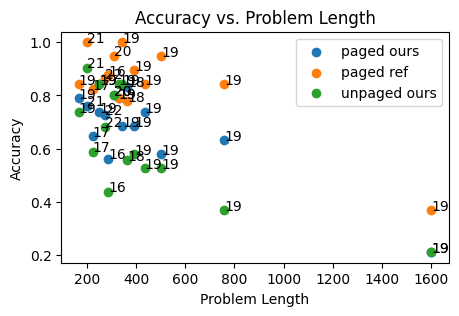

In [63]:
# get data on correct vs. incorrect predictions
# 0918_save_outputs_paged_no_trunc
# 0918_save_outputs_paged_10
tag1 = "0918_save_outputs_paged_no_trunc"
remap1 = "paged ours"
tag2 = "save_reference_v2_0916"
remap2 = "paged ref"
tag3 = "save_outputs_v6/"
remap3 = "unpaged ours"
tags = [tag1, tag2, tag3]
tag2remap = {tag1: remap1, tag2: remap2, tag3: remap3}

dics = []
for i, tag in enumerate(tags):
    scores_path = f"/home/rahul/code/lm-evaluation-harness/{tag}/__data__rahul__models__Meta-Llama-3.1-405B/"
    scores_files = [f for f in os.listdir(scores_path) if 'samples_mmlu' in f]
    question2acc = defaultdict(dict)
    for f in scores_files:
        with open(f"{scores_path}/{f}") as _f:
            data = jsonlines.Reader(_f)
            data = list(data)
        for d in data:
            acc = d['acc']
            input = d['arguments']['gen_args_0']['arg_0']
            question = d['doc']['question']
            question = question.split("A: ")[0].strip().replace(" ", "")
            question2acc[question] = {
                "acc": acc,
                "len": len(input.split())
            }
    print(f"{len(question2acc)} questions found in {len(scores_files)} files -- average acc: {sum([v['acc'] for v in question2acc.values()]) / len(question2acc)}")
    dics.append(question2acc)
    # if i == 1: break

# plot
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
ax = axs
ax.set_ylabel('Accuracy')
ax.set_xlabel('Problem Length')
ax.set_title(f"Accuracy vs. Problem Length")
for tag, dic in zip(tags, dics):
    df = pd.DataFrame(dic.values())
    df['group'] = pd.qcut(df['len'], q=15, labels=False)
    df['group_size'] = df.groupby('group')['len'].transform('size')
    df['group_len'] = df.groupby('group')['len'].transform('mean')
    df = df.groupby('group').mean().reset_index()
    for i, row in df.iterrows():
        ax.text(row['group_len'], row['acc'], int(row['group_size']))
    plt.scatter(df['group_len'], df['acc'], label=tag2remap[tag])
plt.legend()
plt.show()

### MSE and correlations.

In [133]:
# understand if there's a correlation between RSME and accuracy 
# lm_harness_tag = 'save_outputs_v6'
# expt_tag = 'v4'
# state_fpath = f'/data/simran/mmlu_hybrid_outputs_{expt_tag}/'
# y_fpath = f'/data/simran/mmlu_hybrid_y_outs_{expt_tag}/'
# problems_path = f'/data/simran/mmlu_hybrid_inputs_{expt_tag}/'

lm_harness_tag = 'save_outputs_cria_rp'
expt_tag = '_cria_rp_1670'
state_fpath = f'/data/simran/mmlu_hybrid_outputs_{expt_tag}/'
y_fpath = f'/data/simran/mmlu_hybrid_y_outs_{expt_tag}/'
problems_path = f'/data/simran/mmlu_hybrid_inputs_{expt_tag}/'

hidden_state_files = [f for f in os.listdir(state_fpath) if '.pt' in f]
ref_states = sorted([f for f in hidden_state_files if 'ref_attn_output' in f])
our_states = sorted([f for f in hidden_state_files if 'our_attn_output' in f])
print(f"{len(ref_states)} ref states found")
print(f"{len(our_states)} our states found")

y_files = [f for f in os.listdir(y_fpath) if '.pt' in f]
ref_y = sorted([f for f in y_files if 'ref_y_out' in f])
our_y = sorted([f for f in y_files if 'our_y_out' in f])
print(f"{len(ref_y)} ref y found")
print(f"{len(our_y)} our y found")

255584 ref states found
255584 our states found
255584 ref y found
255584 our y found


In [134]:
# get data on correct vs. incorrect predictions
scores_path = f"/home/rahul/code/lm-evaluation-harness/{lm_harness_tag}/__data__rahul__models__Meta-Llama-3.1-405B/"
scores_files = [f for f in os.listdir(scores_path) if 'samples_mmlu' in f]

question2acc = {}
for f in scores_files:
    with open(f"{scores_path}/{f}") as _f:
        data = jsonlines.Reader(_f)
        data = list(data)
    for d in data:
        acc = d['acc']
        input = d['arguments']['gen_args_0']['arg_0']
        question = d['doc']['question']
        question = question.split("A: ")[0].strip().replace(" ", "")
        question2acc[question] = acc

# average acc
avg_acc = sum(question2acc.values()) / len(question2acc)
print(f"Average accuracy: {avg_acc}")

Average accuracy: 0.6631578947368421


/tmp/ipykernel_3040656/507735286.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  problem_data = torch.load(f"{problems_path}/{problem}")


Number of problems: 1140
Did not find question for: 0 problems
Number of problems longer than 1024 tokens: 120


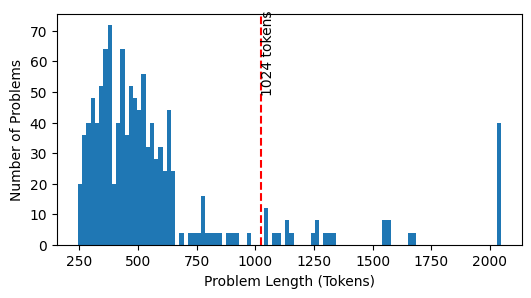

In [135]:
# Load the inputs 
from transformers import AutoTokenizer
tokenizer= AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-405B")
problems = os.listdir(problems_path)
problem_idx_2_data = defaultdict(dict)
dnf = 0
pairs = []
for problem in problems:
    problem_idx = problem.split("=")[-1].split(".")[0]
    problem_data = torch.load(f"{problems_path}/{problem}")
    data = {}
    data['data'] = problem_data
    data['len'] = problem_data.shape[0]
    data['text'] = tokenizer.decode(problem_data)
    question = data['text'].split("\n\n")[-1].split("A. ")[0].strip()
    question = question.split("A: ")[0].strip().replace(" ", "")
    if question in question2acc:
        data['acc'] = question2acc[question]
    else:
        dnf += 1
        pairs.append((data['text'], question))
        # print(f"sad: {question}")
    problem_idx_2_data[problem_idx] = data
print(f"Number of problems: {len(problem_idx_2_data)}")
print(f"Did not find question for: {dnf} problems")

# plot length distribution
num_problems_longer_than_1024 = sum([1 for problem_idx in problem_idx_2_data if problem_idx_2_data[problem_idx]['len'] > 1024])
problem_lens = [problem_idx_2_data[problem_idx]['len'] for problem_idx in problem_idx_2_data]
plt.hist(problem_lens, bins=100)
# add a vertical line for 1024
plt.axvline(x=1024, color='red', linestyle='--')
# label vertical line
plt.text(1024, 50, '1024 tokens', rotation=90)
plt.xlabel('Problem Length (Tokens)')
plt.ylabel('Number of Problems')
print(f"Number of problems longer than 1024 tokens: {num_problems_longer_than_1024}")

In [136]:
criterion_mse = nn.MSELoss(reduction='mean')
mse_by_problem = defaultdict(list)

problem_ids = set()
skipped = 0

refs = ref_y
ours = our_y
layer2mse = defaultdict(list)
for i in tqdm(range(min(len(refs), len(ours)))):
    ref_path = refs[i]
    our_path = ours[i]
    layer_idx = int(ref_path.split("layer")[1].split(".")[0])
    ref_problem_idx = ref_path.split("problem")[1].split("_")[0]
    our_problem_idx = our_path.split("problem")[1].split("_")[0]
    try:
        assert ref_problem_idx == our_problem_idx, "Problem indexes do not match"
    except:
        skipped += 1
        continue

    # get mse
    if "problem0" in ref_path: continue
    ref = torch.load(f"{y_fpath}/{ref_path}")
    our = torch.load(f"{y_fpath}/{our_path}")
    try: loss_mse = criterion_mse(ref[-1], our[-1])
    except:
        skipped += 1
        continue

    if ref_problem_idx not in problem_idx_2_data: continue
    if 'len' not in problem_idx_2_data[ref_problem_idx]: continue
    length = problem_idx_2_data[ref_problem_idx]['len']
    acc = problem_idx_2_data[ref_problem_idx]['acc']
    layer2mse[layer_idx].append({
        'layer': layer_idx,
        'mse': loss_mse.item(),
        'length': length,
        'acc': acc,
        "shape": ref[-1].shape
    })
    if ref_problem_idx not in problem_ids:
        problem_ids.add(ref_problem_idx)

print(f"Added {len(problem_ids)} problems")
print(f"Skipped {skipped} problems")

  0%|          | 0/255584 [00:00<?, ?it/s]/tmp/ipykernel_3040656/487764389.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ref = torch.load(f"{y_fpath}/{ref_path}")
/tm

Added 1140 problems
Skipped 0 problems


In [139]:
# write layer2mse to a file
# import json
# outpath = f'/home/rahul/code/output_data/layer2mse_{expt_tag}.json'
# with open(outpath, 'w') as f:
#     json.dump(layer2mse, f)
# layer2mse = json.load(open(outpath, 'r'))

In [148]:
layer2mse[0][0]

{'layer': 0,
 'mse': 1.1117663234472275e-08,
 'length': 277,
 'acc': 1.0,
 'shape': torch.Size([16384])}

#### Analysis

Text(0, 0.5, 'Problem Length')

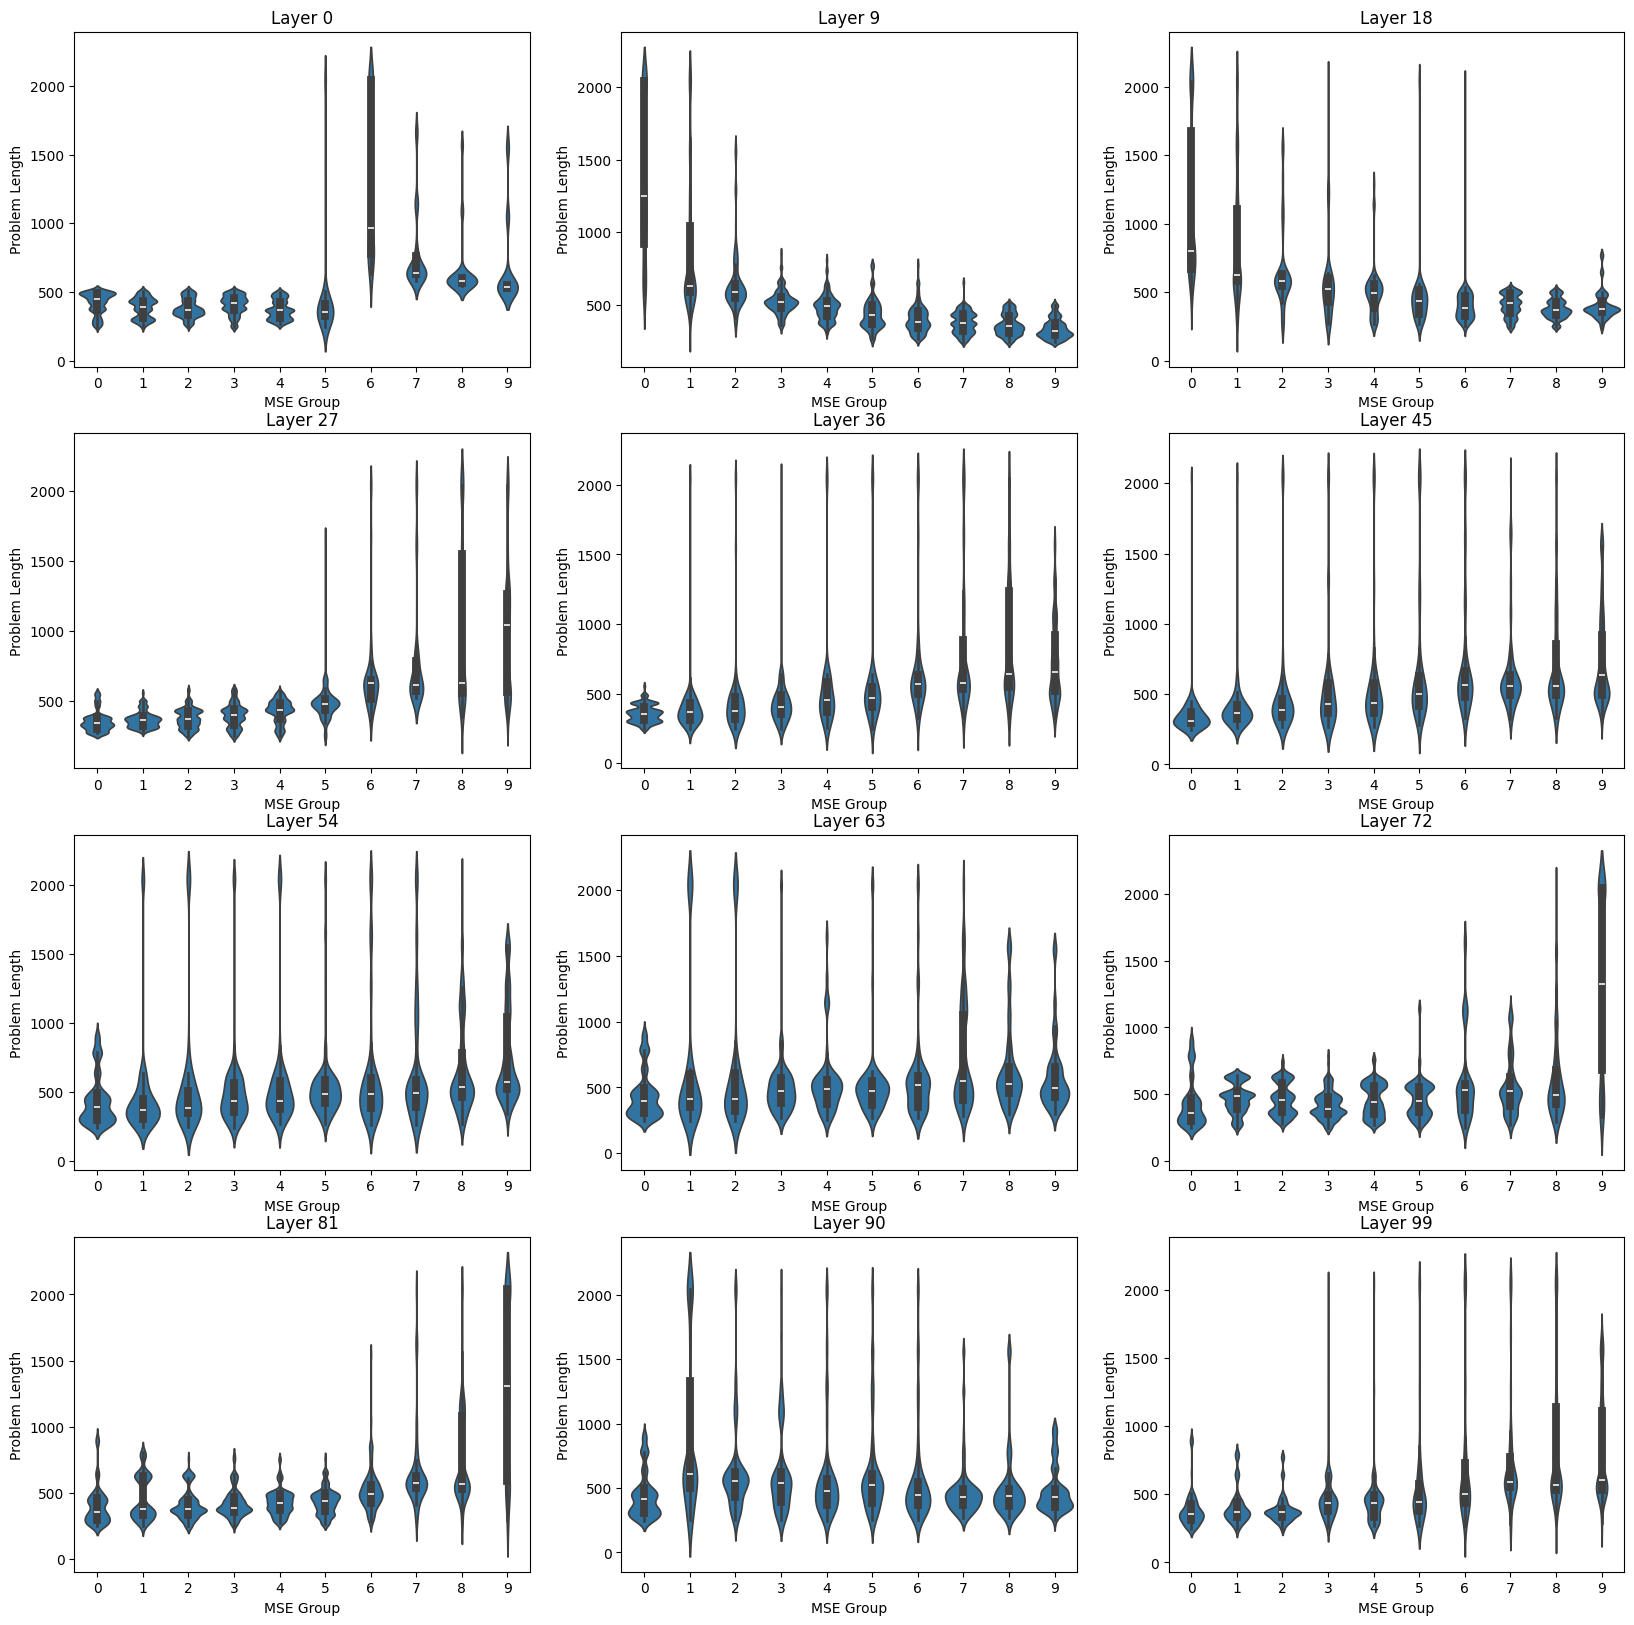

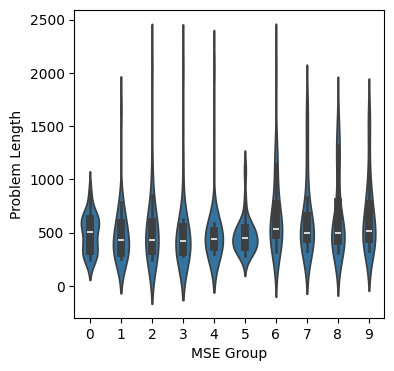

In [142]:
# now make them violin plots
fig, axs = plt.subplots(4, 3, figsize=(20, 20))
# sort by layer_idx as int
layer2mse = {int(k): v for k, v in layer2mse.items()}
layer2mse = dict(sorted(layer2mse.items(), key=lambda x: x[0]))
for i, layer_idx in enumerate(layer2mse):
    if i > 11: break
    data = layer2mse[layer_idx]
    df = pd.DataFrame(data)
    df['group'] = pd.qcut(df['mse'], q=10, labels=False)
    ax = axs[i//3, i%3]
    sns.violinplot(x='group', y='length', data=df, ax=ax)
    ax.set_xlabel('MSE Group')
    ax.set_ylabel('Problem Length')
    ax.set_title(f"Layer {layer_idx}")

# make violin plot for avg_mse by problem length like above, across all layers
avg_mse_by_length = defaultdict(list)
for layer_idx in layer2mse:
    data = layer2mse[layer_idx]
    for d in data:
        avg_mse_by_length[d['length']].append(d['mse'])

avg_mse_by_length = {k: sum(v) / len(v) for k, v in avg_mse_by_length.items()}
df = pd.DataFrame(avg_mse_by_length.items(), columns=['length', 'avg_mse'])
df['group'] = pd.qcut(df['avg_mse'], q=10, labels=False)
plt.figure(figsize=(4, 4))
sns.violinplot(x='group', y='length', data=df)
plt.xlabel('MSE Group')
plt.ylabel('Problem Length')

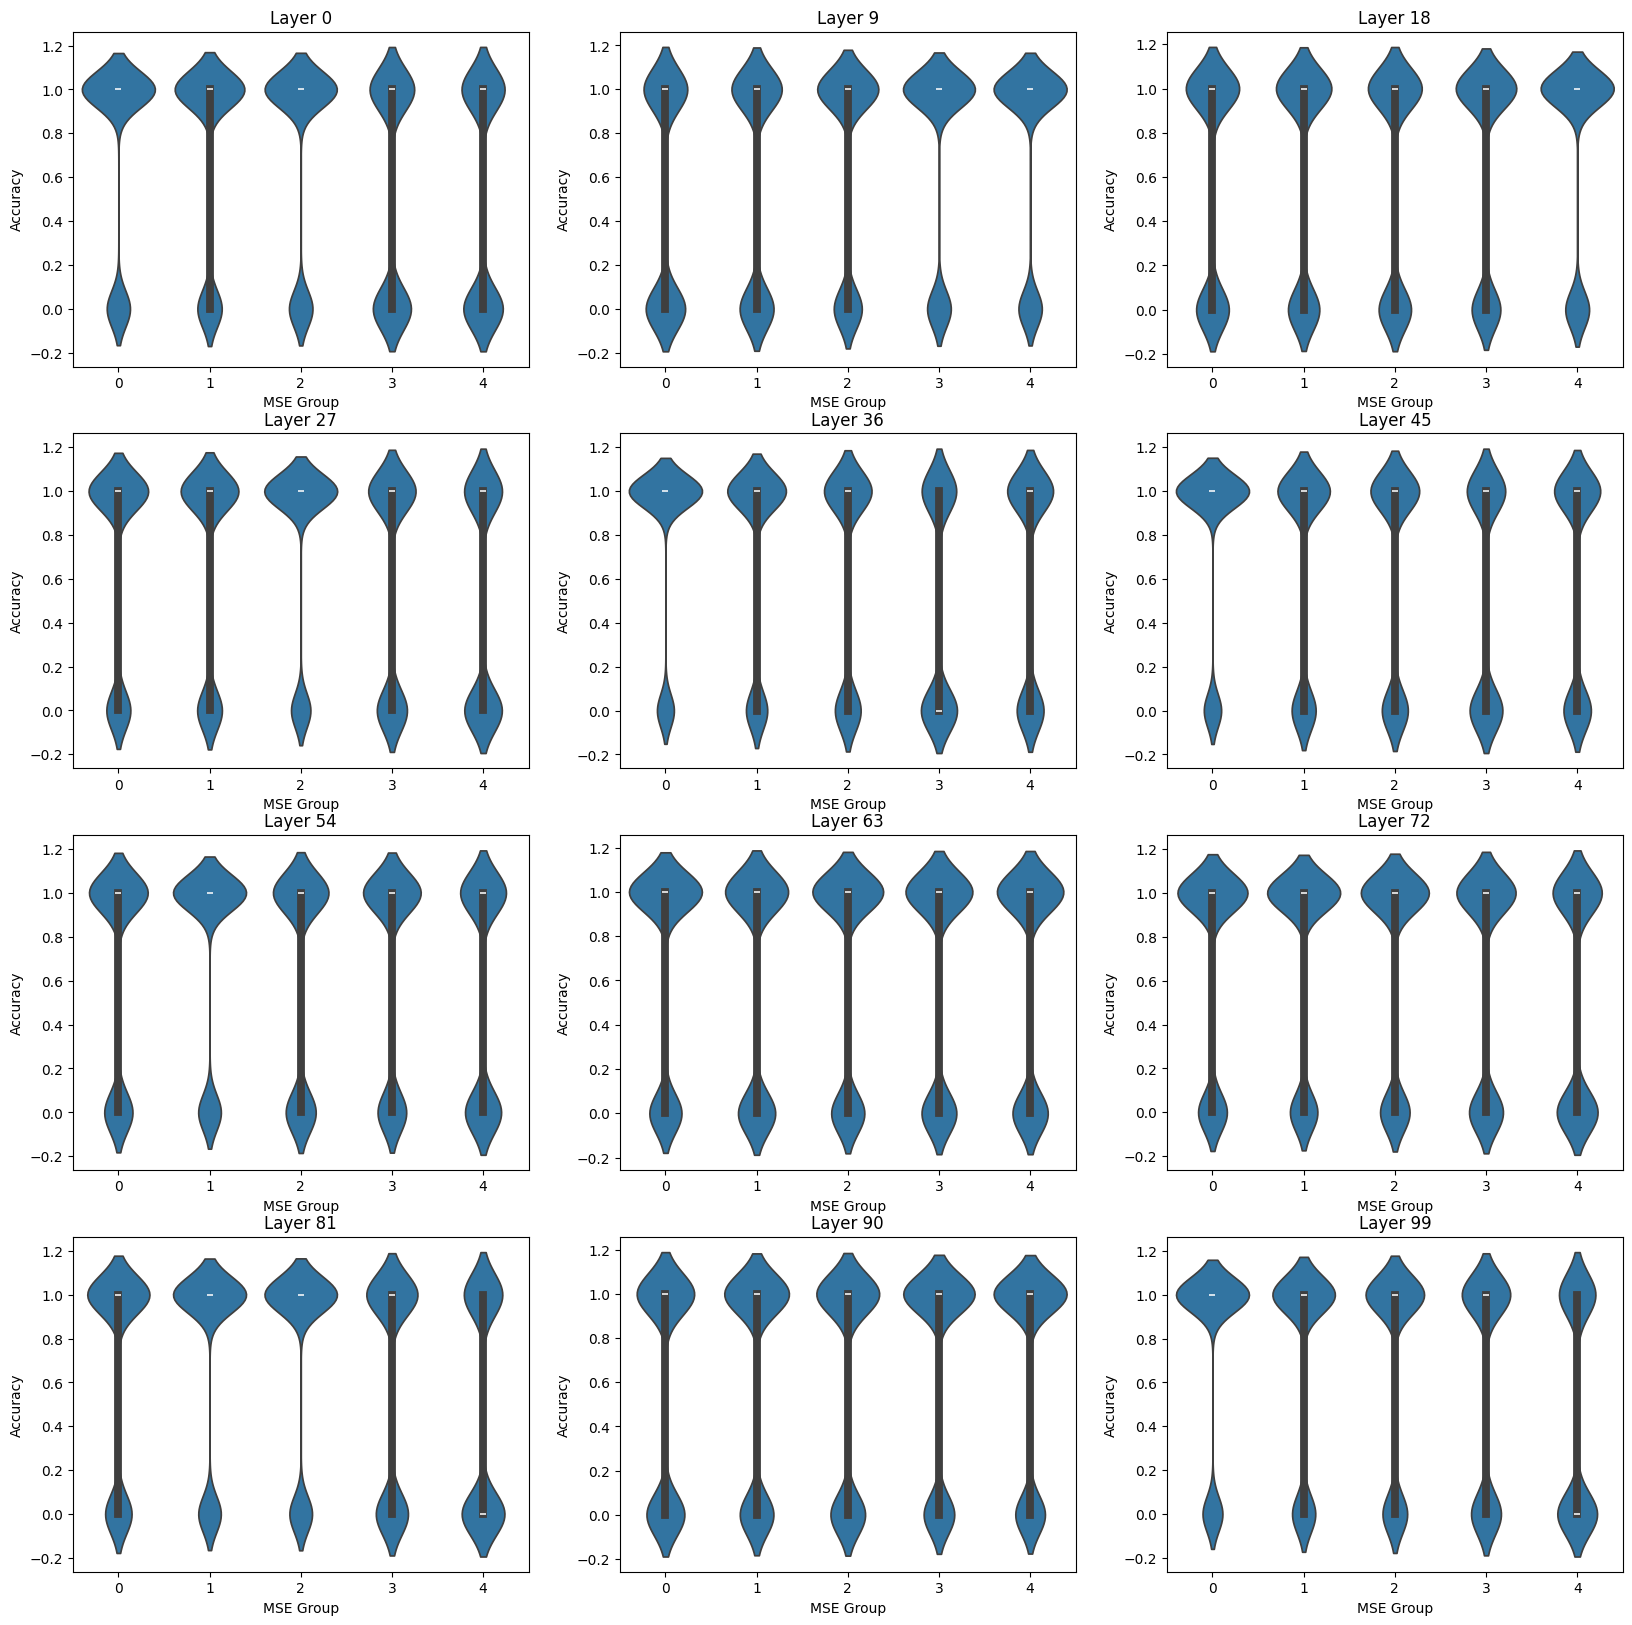

In [144]:
# plot the the accuracy vs. mse as violin plots
fig, axs = plt.subplots(4, 3, figsize=(20, 20))

for i, layer_idx in enumerate(layer2mse):
    if i > 11: break
    data = layer2mse[layer_idx]
    df = pd.DataFrame(data)
    df['group'] = pd.qcut(df['mse'], q=5, labels=False)
    ax = axs[i//3, i%3]
    sns.violinplot(x='group', y='acc', data=df, ax=ax)
    ax.set_xlabel('MSE Group')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"Layer {layer_idx}")

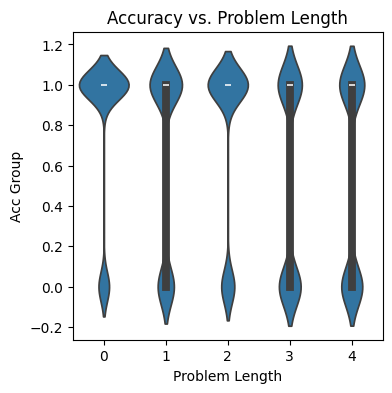

In [145]:
# plot accuracy by problem length
# now make them violin plots
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
for i, layer_idx in enumerate(layer2mse):
    data = layer2mse[layer_idx]
    df = pd.DataFrame(data)
    df['group'] = pd.qcut(df['length'], q=5, labels=False)
    ax = axs
    sns.violinplot(x='group', y='acc', data=df, ax=ax)
    ax.set_ylabel('Acc Group')
    ax.set_xlabel('Problem Length')
    ax.set_title(f"Accuracy vs. Problem Length")
    plt.show()
    break